In [98]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

In [107]:
# Jeu de données initial 
train = pd.read_json("train.json", lines = True)
test = pd.read_json("test.json", lines = True)

# Fichier output
sub = pd.read_csv("sample_submission.csv")

train

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,2395,id_ff84602f7,GGAAAAUAGCAGAGGAAAUACUAGAGCAAUUGCAAAGGCCGAUCAU...,........((..((......))...)).........(((..........,EEEEEEEESSIISSHHHHHHSSIIISSXXXXXXXXXSSSHHHHHHH...,4.036,1,

In [108]:
def divide_set(df, list_column):
    """
    Fonction qui crée d'une fenetre de lecture de 68 bases. 
        :Parameters:
            df = un data frame train
            list_column = numero de la colonne du data frame 
        :Return:
            deux data frame :
                first68_train = data frame contenant les 68 premieres bases et annotations de structure
                last68_train = data frame contenant les 68 dernieres bases et annotations de structure
    """
    first68 = df.copy()
    last68 = df.copy()
    for a in list_column :
        for i, r in enumerate(df.iloc[:,a]):
            first68.iloc[i,a] = r[0:68]
            last68.iloc[i,a] = r[len(r)-68:]
    return first68, last68

In [109]:
# Ces deux variables contiennent les 68 premières et dernières (respectivement), bases et informations de structure
# la colonne 3 correspond à l'information sur les appariements des bases
# la colonne 4 correspond à la prédiction des boucles

first68_train, last68_train = divide_set(train, [2,3,4])

In [110]:
print(len(first68_train.iloc[1,2]))
print(len(last68_train.iloc[1,2]))

68
68


### I) Préparation des données
##### => Nettoyage & préparation des données

In [111]:
# On commence par garder les séquences ARNm qui ont un rapport signal/noise >= 1.

train2 = train.copy()
train2 = train2[train2['signal_to_noise'] >= 1]

print(len(first68_train))
first68_train = first68_train[first68_train['signal_to_noise'] >= 1]
print(len(first68_train))
print(len(train2))

2400
2097
2097


In [112]:
# Création des formats fasta pour voir le pourcentage d'idendité avec CD-HIT web server 
# http://weizhong-lab.ucsd.edu/cdhit-web-server/cgi-bin/index.cgi?cmd=cd-hit
# Nous avons garder les paramètres par defaut

def fasta_file(f, df):
    """
    """
    with open(f,"w") as f_in :
        for line in df.iterrows():
            f_in.write(">" + str(line[1][1]) + "\n" + str(line[1][2]) + "\n")
            
            
fasta_file("train_fasta.fasta", train)
# En persperctive. 

In [113]:
def one_hot_encoding(df, name_colonne):
    """
    Fonction pour encoder les sequences, structures et type boucles : One hot encoding
        :Parameters:
            df = data frame : train et test de départ
            name_colonne = le nom de la colonne du df 
        :Return:
            un tableau
    """
    frst_lst = []
    for r in df[name_colonne]:
        for i in range(len(r)):
            if r[i] not in frst_lst:
                frst_lst.append(r[i])
    dico = {}
    ar = np.zeros(shape=(1,len(frst_lst)),dtype=int)
    for i, l in enumerate(frst_lst):
        ar2 = ar.copy()
        ar2[0][i]=1
        dico[l]=ar2
    scnd_lst = []
    for r in df[name_colonne]:
        lst = [] 
        for i in range(len(r)):
            #print(dico[r[i]], r[i])
            lst.append(dico[r[i]])
        scnd_lst.append(lst)
    return np.array(scnd_lst)

tab = one_hot_encoding(train, 'sequence')
tab2 = one_hot_encoding(train, 'structure')
tab3 = one_hot_encoding(train, 'predicted_loop_type')

train["One_hot seq"] = tab.tolist() # ajout des colonnes encoding a notre DF de départ
train["One hot strucure"] = tab2.tolist()
train["encoding predicted loop"] = tab3.tolist()
train

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,...,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,One_hot seq,One hot strucure,encoding predicted loop
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...",...,"[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000...","[[[1, 0, 0, 0]], [[1, 0, 0, 0]], [[0, 1, 0, 0]...","[[[1, 0, 0]], [[1, 0, 0]], [[1, 0, 0]], [[1, 0...","[[[1, 0, 0, 0, 0, 0, 0]], [[1, 0, 0, 0, 0, 0, ..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...",...,"[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[1, 0, 0, 0]], [[1, 0, 0, 0]], [[0, 1, 0, 0]...","[[[1, 0, 0]], [[1, 0, 0]], [[1, 0, 0]], [[1, 0...","[[[1, 0, 0, 0, 0, 0, 0]], [[1, 0, 0, 0, 0, 0, ..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...",...,"[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499...","[[[1, 0, 0, 0]], [[1, 0, 0, 0]], [[0, 1, 0, 0]...","[[[1, 0, 0]], [[1, 0, 0]], [[1, 0, 0]], [[1, 0...","[[[1, 0, 0, 0, 0, 0, 0]], [[1, 0, 0, 0, 0, 0, ..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...",...,"[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[1, 0, 0, 0]], [[1, 0, 0, 0]], [[0, 1, 0, 0]...","[[[1, 0, 0]], [[1, 0, 0]], [[1, 0, 0]], [[1, 0...","[[[1, 0, 0, 0, 0, 0, 0]], [[1, 0, 0, 0, 0, 0, ..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...",...,"[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,...","[[[1, 0, 0, 0]], [[1, 0, 0, 0]], [[0, 1, 0, 0]...","[[[1, 0, 0]], [[1, 0, 0]], [[1, 0, 0]], [[1, 0...","[[[1, 0,

In [114]:
# Vérification de la bonne taille de DF
print(len((one_hot_encoding(first68_train, 'sequence'))[0]))
print(len((one_hot_encoding(train, 'structure'))[0]))

68
107


In [115]:
# Boucle qui permet de determiner quelle base est apparié dans ce sens : (
dico_open = {}
for i, r in enumerate(first68_train.iterrows()):
    lst = []
    for j, l in enumerate(r[1][3]):
        if l == '(':
            lst.append(j)
    dico_open[str(i)+'('] = lst
dico_open
#len(dico)
# Nouveau dico, qui remplace les indices des bases par la base du dico_open précedent pour l'annotation de structure : (
new_dico_open = {}

for k in dico_open:
    lst = []
    for i in dico_open[k]:
        lst.append(first68_train.iloc[int(k.split('(')[0]),2][i])
    new_dico_open[k] = lst
new_dico_open

{'0(': ['A',
  'G',
  'C',
  'U',
  'C',
  'U',
  'G',
  'G',
  'G',
  'U',
  'U',
  'U',
  'C',
  'U',
  'A',
  'G'],
 '1(': ['G',
  'U',
  'G',
  'C',
  'C',
  'A',
  'G',
  'C',
  'U',
  'A',
  'G',
  'C',
  'U',
  'U',
  'C',
  'G',
  'A'],
 '2(': ['G',
  'G',
  'C',
  'C',
  'G',
  'C',
  'G',
  'C',
  'G',
  'G',
  'U',
  'A',
  'G',
  'C',
  'G',
  'G',
  'G',
  'C'],
 '3(': ['U',
  'U',
  'G',
  'C',
  'A',
  'U',
  'C',
  'G',
  'C',
  'G',
  'A',
  'C',
  'U',
  'C',
  'C',
  'A',
  'C',
  'A',
  'G',
  'C'],
 '4(': ['U',
  'C',
  'A',
  'U',
  'C',
  'G',
  'A',
  'G',
  'G',
  'A',
  'C',
  'G',
  'U',
  'C',
  'C',
  'G',
  'U',
  'U',
  'C',
  'A',
  'A',
  'C',
  'G',
  'C'],
 '5(': ['G',
  'C',
  'A',
  'G',
  'A',
  'C',
  'C',
  'G',
  'A',
  'U',
  'A',
  'C',
  'G',
  'U',
  'A',
  'G',
  'G',
  'A',
  'C',
  'C',
  'U'],
 '6(': ['G',
  'C',
  'G',
  'U',
  'C',
  'U',
  'A',
  'G',
  'G',
  'U',
  'A',
  'U',
  'A',
  'U',
  'G',
  'G',
  'A',
  'U',
  'G',
  'U',


In [116]:
# Boucle qui permet de determiner quelle base est apparié dans le sens : )
dico_close = {}
for i, r in enumerate(first68_train.iterrows()):
    lst = []
    for j, l in enumerate(r[1][3]):
        if l == ')':
            lst.append(j)
    dico_close[str(i)+')'] = lst

# Nouveau dico, qui remplace les indices des bases par la base du dico_close précedent pour l'annotation de structure : )
new_dico_close = {}
for k in dico_close:
    lst = []
    for i in dico_close[k]:
        lst.append(first68_train.iloc[int(k.split(')')[0]),2][i])
    new_dico_close[k] = lst
new_dico_close

{'0)': ['G',
  'G',
  'A',
  'G',
  'C',
  'U',
  'C',
  'U',
  'G',
  'G',
  'A',
  'A',
  'A',
  'C',
  'C',
  'C'],
 '1)': ['A',
  'G',
  'C',
  'U',
  'C',
  'G',
  'A',
  'U',
  'A',
  'G',
  'C',
  'U',
  'G',
  'G',
  'U',
  'A',
  'U'],
 '2)': ['C',
  'G',
  'C',
  'U',
  'A',
  'C',
  'C',
  'G',
  'C',
  'C',
  'G',
  'C',
  'G',
  'C',
  'G',
  'G',
  'C',
  'C'],
 '3)': ['G',
  'C',
  'U',
  'G',
  'U',
  'G',
  'G',
  'A',
  'G',
  'U',
  'C',
  'G',
  'C',
  'G',
  'A',
  'U',
  'G',
  'C',
  'A',
  'A'],
 '4)': ['G',
  'C',
  'G',
  'U',
  'U',
  'G',
  'A',
  'A',
  'C',
  'G',
  'G',
  'A',
  'C',
  'G',
  'U',
  'C',
  'C',
  'U',
  'C',
  'G',
  'A',
  'U',
  'G',
  'A'],
 '5)': ['A',
  'U',
  'C',
  'G',
  'G',
  'U',
  'C',
  'U',
  'G',
  'C',
  'A',
  'G',
  'G',
  'U',
  'U',
  'C',
  'U',
  'A',
  'C',
  'G',
  'U'],
 '6)': ['U',
  'U',
  'A',
  'U',
  'A',
  'A',
  'C',
  'A',
  'U',
  'C',
  'C',
  'A',
  'U',
  'G',
  'U',
  'A',
  'U',
  'U',
  'U',
  'A',


In [117]:
# Recherche des séquences qui n'ont pas le meme nombre de parenthèse ourverte et de parenthèse fermée.
for k in new_dico_open:
    if len(new_dico_open[k]) != len(new_dico_close[k.split('(')[0]+')']):
        print(k)
        print(len(new_dico_open[k]),len(new_dico_close[k.split('(')[0]+')']))

626(
12 11
1820(
27 14


In [118]:
# Code qui permet de donner le nombre de ( par base 

liste4 = []
tmp = -1
dty = {}
for k in new_dico_open:
    if (tmp != i) & (len(dty) > 0) :
        liste4.append(dty)
        dty = {}
    i = ''.join(x for x in k if x.isdigit())
    tmp = i
    for i in range(len(new_dico_open[k])):
        if new_dico_open[k][i] in dty:
            dty[new_dico_open[k][i]] += 1
        else :
            dty[new_dico_open[k][i]] = 1

liste4

[{'A': 2, 'G': 5, 'C': 3, 'U': 6},
 {'G': 5, 'U': 4, 'C': 5, 'A': 3},
 {'G': 10, 'C': 6, 'U': 1, 'A': 1},
 {'U': 4, 'G': 4, 'C': 8, 'A': 4},
 {'U': 5, 'C': 8, 'A': 5, 'G': 6},
 {'G': 6, 'C': 6, 'A': 6, 'U': 3},
 {'G': 9, 'C': 2, 'U': 9, 'A': 5},
 {'G': 7, 'C': 7, 'A': 4, 'U': 1},
 {'G': 3, 'U': 2, 'C': 1, 'A': 3},
 {'G': 7, 'C': 6, 'A': 5, 'U': 4},
 {'G': 9, 'C': 5, 'A': 2, 'U': 2},
 {'C': 5, 'G': 5, 'U': 5, 'A': 4},
 {'U': 4, 'C': 5, 'A': 4, 'G': 6},
 {'G': 7, 'C': 7, 'A': 3, 'U': 5},
 {'A': 1, 'U': 9, 'G': 5, 'C': 5},
 {'A': 3, 'G': 4, 'C': 3, 'U': 7},
 {'G': 6, 'C': 8, 'A': 6, 'U': 1},
 {'G': 7, 'C': 4, 'A': 3, 'U': 3},
 {'C': 6, 'G': 9, 'U': 4, 'A': 5},
 {'G': 7, 'U': 4, 'C': 4},
 {'G': 4, 'U': 5, 'A': 3, 'C': 3},
 {'U': 6, 'A': 1, 'C': 4, 'G': 4},
 {'C': 9, 'U': 4, 'G': 7, 'A': 4},
 {'A': 3, 'C': 7, 'G': 8, 'U': 3},
 {'C': 2, 'G': 8, 'U': 3, 'A': 3},
 {'C': 3, 'G': 2, 'A': 2, 'U': 1},
 {'C': 7, 'U': 8, 'A': 4, 'G': 4},
 {'G': 5, 'C': 5, 'A': 6, 'U': 3},
 {'G': 1, 'U': 1, 'A': 1, '

In [119]:
# Code qui permet de donner le nombre de ) par base

liste5 = []
tmp = -1
dty2 = {}
for k in new_dico_close:
    if (tmp != i) & (len(dty2) > 0) :
        liste5.append(dty2)
        dty2 = {}
    i = ''.join(x for x in k if x.isdigit())
    tmp = i
    for i in range(len(new_dico_close[k])):
        if new_dico_close[k][i] in dty2:
            dty2[new_dico_close[k][i]] += 1
        else :
            dty2[new_dico_close[k][i]] = 1
liste5

[{'G': 5, 'A': 4, 'C': 5, 'U': 2},
 {'A': 4, 'G': 5, 'C': 3, 'U': 5},
 {'C': 10, 'G': 6, 'U': 1, 'A': 1},
 {'G': 8, 'C': 4, 'U': 4, 'A': 4},
 {'G': 8, 'C': 6, 'U': 5, 'A': 5},
 {'A': 3, 'U': 7, 'C': 5, 'G': 6},
 {'U': 9, 'A': 8, 'C': 5, 'G': 3},
 {'C': 7, 'A': 1, 'G': 7, 'U': 4},
 {'G': 1, 'A': 2, 'U': 4, 'C': 2},
 {'C': 7, 'G': 6, 'U': 5, 'A': 4},
 {'C': 9, 'G': 6, 'A': 1, 'U': 2},
 {'C': 5, 'G': 6, 'A': 4, 'U': 4},
 {'G': 6, 'U': 6, 'C': 4, 'A': 3},
 {'G': 8, 'U': 5, 'A': 4, 'C': 5},
 {'C': 5, 'A': 9, 'G': 5, 'U': 1},
 {'G': 6, 'A': 4, 'C': 4, 'U': 3},
 {'G': 8, 'C': 5, 'A': 1, 'U': 7},
 {'C': 6, 'G': 5, 'U': 4, 'A': 2},
 {'G': 6, 'C': 9, 'U': 5, 'A': 4},
 {'C': 6, 'A': 4, 'G': 4, 'U': 1},
 {'G': 4, 'A': 4, 'U': 4, 'C': 3},
 {'G': 6, 'C': 3, 'A': 4, 'U': 2},
 {'C': 6, 'G': 11, 'A': 2, 'U': 5},
 {'C': 6, 'G': 9, 'U': 5, 'A': 1},
 {'G': 3, 'C': 5, 'A': 2, 'U': 6},
 {'G': 3, 'A': 1, 'U': 2, 'C': 2},
 {'C': 4, 'G': 7, 'A': 8, 'U': 4},
 {'A': 2, 'C': 5, 'G': 6, 'U': 6},
 {'G': 1, 'U': 1, 

### II) Analyse exploratoire des données
#### a) Répresentation du signal/noise des séquence


1.0
17.194


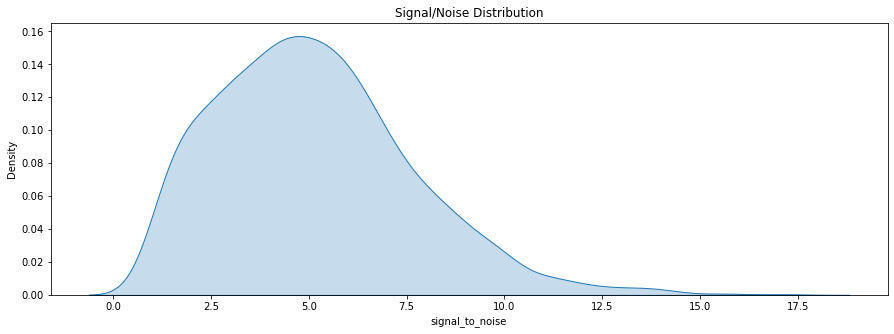

In [131]:
# faire une representation du signal_noise : expérience foirer ou pas ?
# est-ce que un signal noise faible = un tx de dégradation élévée ?

fig, ax = plt.subplots(figsize=(15, 5))
sns.kdeplot(train2['signal_to_noise'], shade=True, ax=ax)

ax.set_title('Signal/Noise Distribution')
print(min(train2['signal_to_noise']))
print(max(train2['signal_to_noise']))


In [121]:
def dico_nbr(lst):
    """
    Fonction qui prend une liste de sequence de base/structure ou 
    prediction de loop et qui retourne un dictionnaire de nombre de chacune 
    des base ou type de structure.
        :Paramètres:
            lst = liste 
        :Return:
            un dico dont les clefs seront les base ou les structures et en valeurs
            le nombre de fois qu'il les trouves
    """
    seq_list = []
    for b in lst :
        if b not in lst:
            lst.append(b)

    dico = {}

    for b in lst:
        dico[b] = lst.count(b)
    
    return dico


def max_dstrb_df(df, col):
    """
    Fonction qui renvoie des dictionnaires dont les clefs sont le type de bases, le type de structures et le type de loop
    et en valeurs le nombre de fois qu'on les retrouve dans le data frame.
    Ce contage ce fait en fonction de la valeur maximum de la degradation/réactivité au autres variable à prédire.
        :Paramètres:
            df : train
            colonne du train : 'reactivity' par exemple
        :Return:
            3 dictionnaires contenant le nombre de bases, de type de structures et de type de loop 
    """
    base = []
    struct = []
    loop = []
    
    for line in df.iterrows():
        base.append(line[1]['sequence'][line[1][col].index(max(line[1][col]))])
        struct.append(line[1]['structure'][line[1][col].index(max(line[1][col]))])
        loop.append(line[1]['predicted_loop_type'][line[1][col].index(max(line[1][col]))])
    
    di_base = dico_nbr(base)
    di_strct = dico_nbr(struct)
    di_loop = dico_nbr(loop)

    
    return di_base, di_strct, di_loop

def min_dstrb_df(df, col):
    """
    Fonction qui renvoie ds dictionnaires dont les clefs sont le type de bases, le type de structures et le type de loop
    et en valeurs le nombre de fois qu'on les retrouve dans le data frame.
    Ce contage ce fait en fonction de la valeur minimum de la degradation/réactivité au autres variable à prédire.
        :Paramètres: 
            df : train
            colonne du train : 'reactivity' par exemple
        :Return:
            3 dictionnaires contenant le nombre de bases, de type de structures et de type de loop        
    """
    base = []
    struct = []
    loop = []
    
    for line in df.iterrows():
        base.append(line[1]['sequence'][line[1][col].index(min(line[1][col]))])
        struct.append(line[1]['structure'][line[1][col].index(min(line[1][col]))])
        loop.append(line[1]['predicted_loop_type'][line[1][col].index(min(line[1][col]))])
    
    di_base = dico_nbr(base)
    di_strct = dico_nbr(struct)
    di_loop = dico_nbr(loop)

    
    return di_base, di_strct, di_loop

##### b) Representation des données de séquence

In [84]:
max_base_rea, max_strct_rea, max_loop_rea = max_dstrb_df(train2, "reactivity")
# min_base_rea, min_strct_rea, min_loop_rea = min_dstrb_df(train, "reactivity")

max_base_MGph, max_strct_MGph, max_loop_MGph = max_dstrb_df(train2, "deg_Mg_pH10")
# min_base_MGph, min_strct_MGph, min_loop_MGph = min_dstrb_df(train, "deg_Mg_pH10")

max_base_ph, max_strct_ph, max_loop_ph = max_dstrb_df(train2, "deg_pH10")
# min_base_ph, min_strct_ph, min_loop_ph = min_dstrb_df(train, "deg_pH10")

max_base_MG50, max_strct_MG50, max_loop_MG50 = max_dstrb_df(train2, "deg_Mg_50C")
# min_base_MG50, min_strct_MG50, min_loop_MG50 = min_dstrb_df(train, "deg_Mg_50C")

max_base_50, max_strct_50, max_loop_50 = max_dstrb_df(train2, "deg_50C")
# min_base_50, min_strct_50, min_loop_50 = min_dstrb_df(train, "deg_50C")

# Pour l'instant on cherche à savoir quelle base se dégrade le plus et pas celle qui protège de la dégradation. 
# On cherche donc que le maximum pour l'instant. Le min peut etre en perspective


In [85]:
# Transformation de en df pour plot
# On a chercher le valeux de la réactivité et du taux de dégradation MG_ph10 maximales pour chaque séquence d'ARNm
# On a chercher quelle base était associée cette valeur, et on a compter le nombre de chaque base. 
# Plot des resultats plus bas

df_base_rea_max = pd.DataFrame(max_base_rea.items(), columns = ['base', 'number'])
df_base_deg_max = pd.DataFrame(max_base_MGph.items(), columns = ['base', 'number'])

df_base_rea_max = df_base_rea_max.sort_values(by=['base'])
df_base_deg_max = df_base_deg_max.sort_values(by=['base'])

print(df_base_rea_max)
print(df_base_deg_max)

# new_df2 = pd.DataFrame(d_strct_ph.items(), columns=['struct', 'number'])

  base  number
0    A     856
3    C      36
1    G    1010
2    U     195
  base  number
1    A     613
2    C      83
0    G    1201
3    U     200


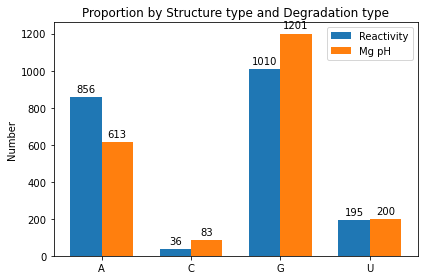

In [86]:
labels = df_base_rea_max['base']
rea = list(df_base_rea_max['number'])
mgph = list(df_base_deg_max['number'])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rea, width, label='Reactivity')
rects2 = ax.bar(x + width/2, mgph, width, label='Mg pH')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number')
ax.set_title('Proportion by Structure type and Degradation type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# Donc ci dessous on voit que la base G est la base qui a le taux de degradation le plus élevé. 
# Sur 2097 séquence(on a pris le data propre = sans le signal noise)
# on voit que sur ces 2097 séqeunce,  1201 sequence ont comme base avec le taux de reactivité et de degradations
# les plus élevés une base G. 

In [87]:
# On va faire la meme chose pour voir les 5 variables : 
# reactivité, deg_Mg_ph10 deg_ph10 deg_MG_50 deg_50
# Puis on va plot
df_base_rea_max = pd.DataFrame(max_base_rea.items(), columns = ['base', 'number'])
df_base_deg_max = pd.DataFrame(max_base_MGph.items(), columns = ['base', 'number'])

df_base_rea_max = df_base_rea_max.sort_values(by=['base'])
df_base_deg_max = df_base_deg_max.sort_values(by=['base'])

df_base_ph_max = pd.DataFrame(max_base_ph.items(), columns = ['base', 'number'])
df_base_mg_max = pd.DataFrame(max_base_MG50.items(), columns = ['base', 'number'])
df_base_50_max = pd.DataFrame(max_base_50.items(), columns = ['base', 'number'])

df_base_ph_max = df_base_ph_max.sort_values(by=['base'])
df_base_mg_max = df_base_mg_max.sort_values(by=['base'])
df_base_50_max = df_base_50_max.sort_values(by=['base'])



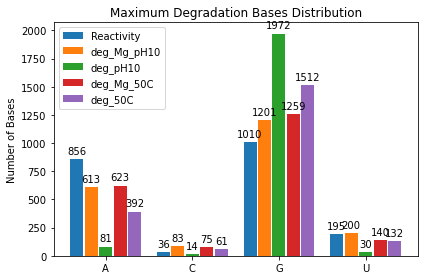

In [88]:
labels = df_base_rea_max['base']
rea = list(df_base_rea_max['number'])
mgph = list(df_base_deg_max['number'])
ph = list(df_base_ph_max['number'])
mg = list(df_base_mg_max['number'])
c50 = list(df_base_50_max['number'])

#x = np.arange(len(labels))  # the label locations
lst = [2, 5, 8, 11]
x = np.array(lst)
#print(x)
width = 0.45  # the width of the bars


fig, ax = plt.subplots()
rects1 = ax.bar(x - 1, rea, width, label='Reactivity')
rects2 = ax.bar(x - 0.5, mgph, width, label='deg_Mg_pH10')
rects3 = ax.bar(x + 0.00, ph, width, label='deg_pH10')
rects4 = ax.bar(x + 0.5, mg, width, label='deg_Mg_50C')
rects5 = ax.bar(x + 1, c50, width, label='deg_50C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Bases')
ax.set_title('Maximum Degradation Bases Distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)

fig.tight_layout()

plt.show()

# Donc voit que la base G est la base la plus suceptible à la dégradation pour toutes les variables de degradations
# suivi de la base A

#### c) Representation des données structurales

In [90]:
# Réprésentation des données structurales

df_strct_rea_max = pd.DataFrame(max_strct_rea.items(), columns = ['structure', 'number'])
df_strct_deg_max = pd.DataFrame(max_strct_MGph.items(), columns = ['structure', 'number'])

df_strct_rea_max = df_strct_rea_max.sort_values(by=['structure'])
df_strct_deg_max = df_strct_deg_max.sort_values(by=['structure'])

df_strct_ph_max = pd.DataFrame(max_strct_ph.items(), columns = ['structure', 'number'])
df_strct_mg_max = pd.DataFrame(max_strct_MG50.items(), columns = ['structure', 'number'])
df_strct_50_max = pd.DataFrame(max_strct_50.items(), columns = ['structure', 'number'])

df_strct_ph_max = df_strct_ph_max.sort_values(by=['structure'])
df_strct_mg_max = df_strct_mg_max.sort_values(by=['structure'])
df_strct_50_max = df_strct_50_max.sort_values(by=['structure'])

df_strct_rea_max



,structure,number
1,(,94
2,),39
0,.,1964


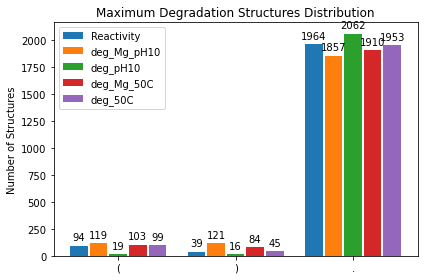

In [92]:
labels = df_strct_rea_max['structure']
rea = list(df_strct_rea_max['number'])
mgph = list(df_strct_deg_max['number'])
ph = list(df_strct_ph_max['number'])
mg = list(df_strct_mg_max['number'])
c50 = list(df_strct_50_max['number'])

#x = np.arange(len(labels))  # the label locations
lst = [2, 5, 8]
x = np.array(lst)
width = 0.45  # the width of the bars


fig, ax = plt.subplots()
rects1 = ax.bar(x - 1, rea, width, label='Reactivity')
rects2 = ax.bar(x - 0.5, mgph, width, label='deg_Mg_pH10')
rects3 = ax.bar(x + 0.00, ph, width, label='deg_pH10')
rects4 = ax.bar(x + 0.5, mg, width, label='deg_Mg_50C')
rects5 = ax.bar(x + 1, c50, width, label='deg_50C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Structures')
ax.set_title('Maximum Degradation Structures Distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)

fig.tight_layout()

plt.show()
# On voit que les bases non appariés sont plus suceptible à la dégradation 

#### d) Representation des données des prédictions des boucles

In [93]:
df_loop_rea_max = pd.DataFrame(max_loop_rea.items(), columns = ['loop_type', 'number'])
df_loop_deg_max = pd.DataFrame(max_loop_MGph.items(), columns = ['loop_type', 'number'])

df_loop_rea_max = df_loop_rea_max.sort_values(by=['loop_type'])
df_loop_deg_max = df_loop_deg_max.sort_values(by=['loop_type'])

df_loop_ph_max = pd.DataFrame(max_loop_ph.items(), columns = ['loop_type', 'number'])
df_loop_mg_max = pd.DataFrame(max_loop_MG50.items(), columns = ['loop_type', 'number'])
df_loop_50_max = pd.DataFrame(max_loop_50.items(), columns = ['loop_type', 'number'])

df_loop_ph_max = df_loop_ph_max.sort_values(by=['loop_type'])
df_loop_mg_max = df_loop_mg_max.sort_values(by=['loop_type'])
df_loop_50_max = df_loop_50_max.sort_values(by=['loop_type'])

df_loop_50_max

,loop_type,number
3,B,11
0,E,1742
1,H,110
4,I,48
2,M,18
6,S,144
5,X,24


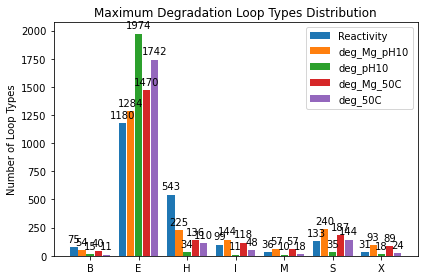

In [94]:
labels = df_loop_rea_max['loop_type']
rea = list(df_loop_rea_max['number'])
mgph = list(df_loop_deg_max['number'])
ph = list(df_loop_ph_max['number'])
mg = list(df_loop_mg_max['number'])
c50 = list(df_loop_50_max['number'])

#x = np.arange(len(labels))  # the label locations
lst = [2, 5, 8, 11, 14, 17, 20]
x = np.array(lst)
width = 0.45  # the width of the bars


fig, ax = plt.subplots()
rects1 = ax.bar(x - 1, rea, width, label='Reactivity')
rects2 = ax.bar(x - 0.5, mgph, width, label='deg_Mg_pH10')
rects3 = ax.bar(x + 0.00, ph, width, label='deg_pH10')
rects4 = ax.bar(x + 0.5, mg, width, label='deg_Mg_50C')
rects5 = ax.bar(x + 1, c50, width, label='deg_50C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Loop Types')
ax.set_title('Maximum Degradation Loop Types Distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)

fig.tight_layout()

plt.show()
# On voit que les boucles E sont les structure les plus susceptible à la dégrdation
#S: paired "Stem"; M: Multiloop; I: Internal loop; B: Bulge; H: Hairpin loop; E: dangling End; X: eXternal loop;

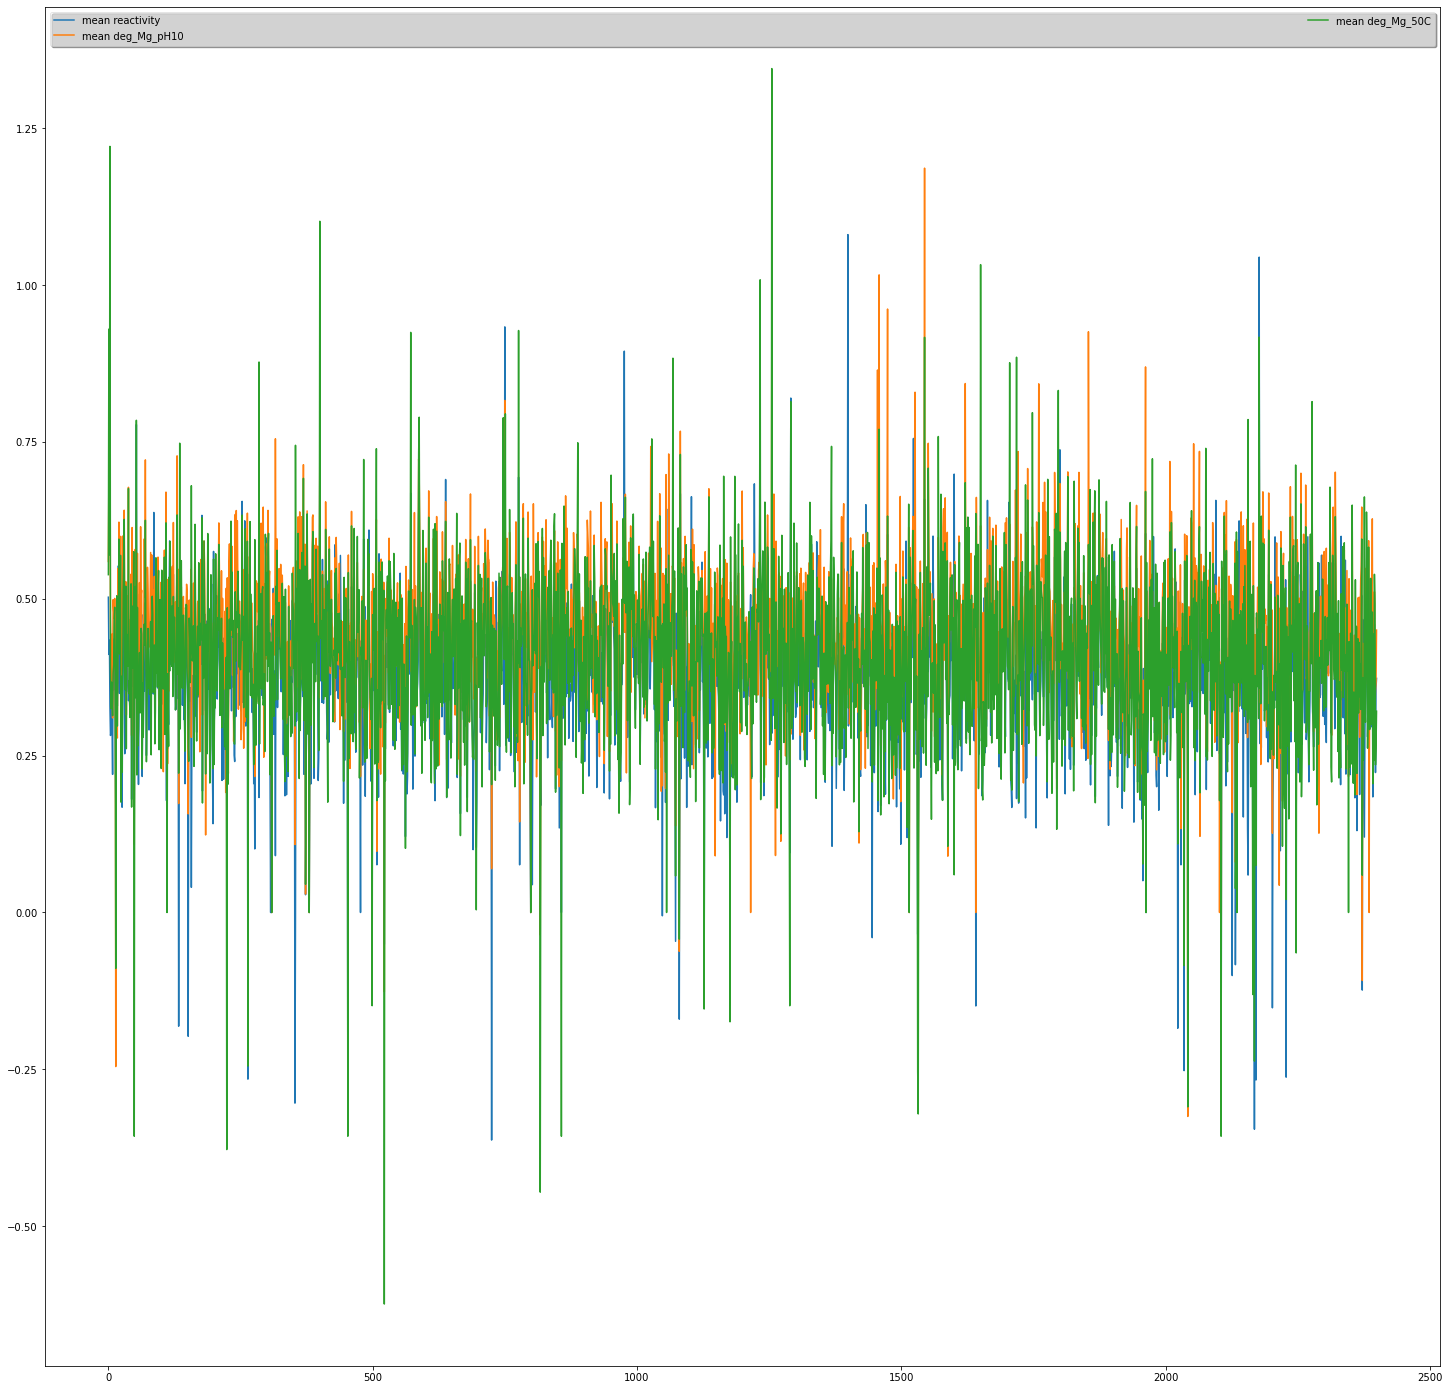

correlation coefficient between MgpH degradation and Mg50C degradation : 0.7226038330795412
correlation coefficient between MgpH degradation and reactivity : 0.6248657274494287
correlation coefficient between Mg50C degradation and reactivity : 0.643630663799499


In [132]:
# On essaye de voir la corrélation des troi variables a prédire
rea_lst = []
mgph_lst = []
mg50c_lst = []

for line in train.iterrows():
    rea_lst.append(np.mean(line[1]['reactivity']))
    mgph_lst.append(np.mean(line[1]['deg_Mg_pH10']))
    mg50c_lst.append(np.mean(line[1]['deg_Mg_50C']))

len(mgph_lst)

figure(figsize=(25,25))

ax = plt.subplot(111)
x = np.arange(0, 2400)

plt.plot(x, rea_lst, label="mean reactivity")
plt.plot(x, mgph_lst, label="mean deg_Mg_pH10")
plt.plot(x, mg50c_lst, label="mean deg_Mg_50C")

leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)


plt.show()

#from scipy.stats.stats import pearsonr

#print(pearsonr(mgph_lst, mg50c_lst)[0])
#print(pearsonr(mgph_lst, rea_lst)[0])
#print(pearsonr(rea_lst, mg50c_lst)[0])


print("correlation coefficient between MgpH degradation and Mg50C degradation :",np.corrcoef(mgph_lst, mg50c_lst)[0, 1])
print("correlation coefficient between MgpH degradation and reactivity :",np.corrcoef(mgph_lst, rea_lst)[0, 1])
print("correlation coefficient between Mg50C degradation and reactivity :",np.corrcoef(rea_lst, mg50c_lst)[0, 1])

# se rapproche de 1 donc correlation ?

In [ ]:
# corrélation entre variables régréssion linéaire sur données output
# Calculer le taux de chaque base de chaque séquence dans le train
# ACP 
